### RAG in LangGraph Workflow

In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import MessageGraph

/home/brian/Documents/JIM/Langgraph/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
llm = ChatGroq(model_name="llama3-8b-8192")

# Load and prepare documents
loader = DirectoryLoader("../data", glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=50)
split_docs = text_splitter.split_documents(docs)

db = Chroma.from_documents(split_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 3})


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [5]:
def llm_brief_answer(messages):
    question = messages[-1].content
    prompt = "Your task is to provide only a brief answer to the user query without much reasoning. Here is the query: " + question
    response = llm.invoke(prompt)
    messages.append(AIMessage(content=response.content))
    return messages

def rag_answer(messages):
    original_question = next(msg.content for msg in messages if isinstance(msg, HumanMessage))
    
    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    result = retrieval_chain.invoke(original_question)

    messages.append(AIMessage(content=result))
    return messages

In [6]:
# Build the MessageGraph
workflow = MessageGraph()
workflow.add_node("LLM", llm_brief_answer)
workflow.add_node("RAG", rag_answer)
workflow.add_edge("LLM", "RAG")
workflow.set_entry_point("LLM")
workflow.set_finish_point("RAG")

In [7]:
app = workflow.compile()

In [ ]:
input_state = [HumanMessage(content="Tell me about llama 3 model")]
for output in app.stream(input_state):
    for node_name, node_messages in output.items():
        print(f"\nOutput for node '{node_name}': ")
        print("-" * 30)
        for message in node_messages:
            print(f"{message.type.capitalize()} Message: {message.content}")
        print("\n" + "=" * 50)


Output for node 'LLM': 
------------------------------
Human Message: Tell me about llama3 model
Ai Message: The llama3 model is a language model developed by LLaMA, a AI research organization. It is a large-scale language model trained on a massive dataset of text and capable of generating human-like responses.



Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given



Output for node 'RAG': 
------------------------------
Human Message: Tell me about llama3 model
Ai Message: The llama3 model is a language model developed by LLaMA, a AI research organization. It is a large-scale language model trained on a massive dataset of text and capable of generating human-like responses.
Ai Message: According to the context, Llama 3 has been described as "surprisingly capable" given its size.



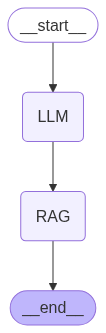

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [7]:
loader2 = DirectoryLoader("../data2", glob="./*.txt", loader_cls=TextLoader)
docs2 = loader2.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap = 50
)

new_docs2 = text_splitter.split_documents(documents=docs2)
doc_string2 = [doc.page_content for doc in new_docs2]

db = Chroma.from_documents(new_docs2, embeddings)
retriever2 = db.as_retriever(search_kwargs = {"k": 3})

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [10]:
query = "Tell me about India's Industrial Growth.?"
docs = retriever2.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': '../data2/indian_economy.txt'}
India’s strong export sectors—including textiles, IT services, and automotive manufacturing—had
page_content='India’s strong export sectors—including textiles, IT services, and automotive manufacturing—had' metadata={'source': '../data2/indian_economy.txt'}
page_content='India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a' metadata={'source': '../data2/indian_economy.txt'}
page_content='India’s last eight years of GDP (hypothetical data):' metadata={'source': '../data2/indian_economy.txt'}


In [11]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate

1. TypedDict:
TypedDict is a special type that allows you to define a dictionary in Python where each key has a specific type. It’s useful when you want to enforce type checks on the keys and values of a dictionary.
2. Annotated:
Annotated is used to add metadata or constraints to a type. It’s typically used for adding additional information, like constraints or descriptions, to the type.
3. Sequence[BaseMessage]:
Sequence is a generic type from Python's typing module that represents a list-like structure (such as a list or tuple) where the order matters, and you can access elements by their position.
4. BaseMessage:
Basemessage: This assumes you're working with the LangChain framework, and BaseMessage is part of its core messaging system. It is typically used when handling or processing messages in LangChain's workflows
5. operator.add:
- operator.add is a function from Python’s operator module that performs addition (+) on its arguments. In this context, operator.add is being used as metadata for the Annotated type, likely suggesting that the sequence of BaseMessage objects is meant to be "added" or concatenated with another sequence at some point. It’s an indicator of how the messages field will be treated in the logic of your program.

- TopicSelectionParser: A Pydantic model that defines two fields (Topic and Reasoning), both of which are required to be strings.

- Field: Adds metadata, like descriptions, and can also be used for validation and constraints.

- Pydantic’s Role: Ensures that the data matches the expected structure and types, raising validation errors if the data is invalid.

In [25]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

#### Putting It All Together:
- The line messages: Annotated[Sequence[BaseMessage], operator.add] defines a field messages that:

- Must be a sequence (like a list or tuple) of BaseMessage objects. Has the additional annotation operator.add, which suggests that this sequence is intended to support addition (i.e., concatenation of multiple sequences of messages).

messages: Annotated[Sequence[BaseMessage], operator.add]
"messages": [BaseMessage("Hello!", "Alice"), BaseMessage("Hi!", "Bob")]

In [26]:
from pydantic import BaseModel, Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description = "Selected Topic")
    Reasoning: str = Field(description = "Reasoning behind topic selection")
    

In [27]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object = TopicSelectionParser)

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


template=""" Your task is to classify the given user query into one of the following categories: [India, Not Related]. Only respond with the category name and nothing else.

User query: "Tell me about India's Industrial Growth"
The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
    """

In [28]:
def function_1(state: AgentState):
    messages = state["messages"]
    question=messages[-1].content
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [India, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                                    input_variables=['question'],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()}
                                    )
    chain =  prompt | llm | parser
    
    response = chain.invoke({"question": question})
    print(response)

    return {"messages": [HumanMessage(content=response.Topic)]}

In [29]:
def router(state: AgentState):
    print('-> Router ->')
    messages = state['messages']
    last_message = messages[-1].content
    print(last_message)
    if 'India' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [30]:
def function_2(state: AgentState):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[-1].content
    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    print(prompt)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return {"messages": [HumanMessage(content=result)]}

In [31]:
def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[-1].content
    complete_query = "Answer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [HumanMessage(content=response.content)]}

In [32]:
from langgraph.graph import StateGraph, END

workflow_one = StateGraph(AgentState)

workflow_one.add_node("agent", function_1)

workflow_one.add_node("RAG", function_2)

workflow_one.add_node("LLM", function_3)

workflow_one.set_entry_point("agent")

workflow_one.add_conditional_edges(
    
    "agent",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

workflow_one.add_edge("RAG", END)
workflow_one.add_edge("LLM", END)
app_one = workflow_one.compile()

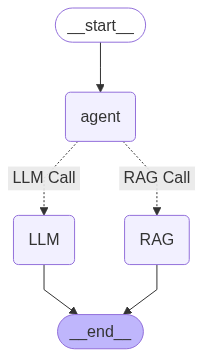

In [21]:
from IPython.display import Image, display

try:
    display(Image(app_one.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [33]:
input = {"messages": [HumanMessage(content="Tell me about India's Industrial Growth?")]}

In [34]:
output = app_one.invoke(input)
print(output)

Tell me about India's Industrial Growth?
Topic='India' Reasoning="User query is about India's Industrial Growth"
-> Router ->
India
-> Calling RAG ->
India
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]
{'messages': [HumanMessage(content="Tell me about India's Industrial Growth?", additional_kwargs={}, response_metadata={}), HumanMessage(content='India', additional_kwargs={}, response_metadata={}), HumanMessage(content="Based on the provided context, here's an answer:\n\nIndia has a strong export sector, including textiles, IT services, and automotive manufacturing, as well as a demand for Indian IT services and pharmaceuticals.", additional_kwargs={}, response_metadata={})]}


In [35]:
output

{'messages': [HumanMessage(content="Tell me about India's Industrial Growth?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='India', additional_kwargs={}, response_metadata={}),
  HumanMessage(content="Based on the provided context, here's an answer:\n\nIndia has a strong export sector, including textiles, IT services, and automotive manufacturing, as well as a demand for Indian IT services and pharmaceuticals.", additional_kwargs={}, response_metadata={})]}

In [38]:
inputs = {"messages": [HumanMessage(content="Where is Paris")]}

In [39]:
output = app_one.invoke(inputs)

Where is Paris
Topic='Not Related' Reasoning='Query is about Paris which is not related to India'
-> Router ->
Not Related
-> Calling LLM ->


In [45]:
inputs = {"messages": [HumanMessage(content="Who is King of England")]}

In [46]:
output1 = app_one.invoke(inputs)

Who is King of England
Topic='Not Related' Reasoning='The query is about the King of England, but it is not related to India'
-> Router ->
Not Related
-> Calling LLM ->


In [47]:
output1

{'messages': [HumanMessage(content='Who is King of England', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Not Related', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='A clever question!\n\nSince the question "Not Related" doesn\'t specify a topic or ask about a particular issue, I\'ll take it as an opportunity to provide a humorous response.\n\nIn that case, I\'d say that the answer is "Pizza"! Because, you know, pizza is a delicious food that\'s not related to anything in particular... but can be related to your stomach, your taste buds, and your happiness', additional_kwargs={}, response_metadata={})]}